# Project Notebook - Machine Learning I

### Libraries

In [1]:
import pandas as pd
import numpy as np
import openml
from AdaBoostClassifier import AdaBoost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import scipy.stats as ss
import scikit_posthocs as sp
import matplotlib.pyplot as plt

### Get the datasets to use throughout the project

Function to read a dataset from [OpenML-CC18 Curated Classification benchmark](https://www.openml.org/search?type=study&sort=tasks_included&study_type=task&id=99 "OpenML-CC18") givent its Task ID and return the corresponding Pandas Dataframe

In [2]:
def getDataset(task_id):
    suite = openml.study.get_suite(99)
    task = openml.tasks.get_task(task_id)    
    dataset = openml.datasets.get_dataset(task.dataset_id)

    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )

    df = pd.DataFrame(X, columns=attribute_names)
    # converter:
    #   0 -> -1
    #   1 -> 1
    df['target'] = 2*y-1 
    # erase rows with NaN values
    df = df.dropna(how='any', axis=0)

    return df

Description of the datasets used in this project:
- Dataset about breast cancer, with 683 entries;
- Dataset about mushrooms, with 5644 entries;
- Dataset made with synthetic data, with 10880 entries;
- Dataset about , with 3279 entries;

In [3]:
datasets = [
    ("Task ID = 15", getDataset(15)),
    ("Task ID = 24", getDataset(24)),
    ("Task ID = 3904", getDataset(3904)),
    ("Task ID = 146820", getDataset(146820))
]

### Performance evaluation of AdaBoost

To get a better understanding of how AdaBoost behaves with the chosen datasets,, we implemented the function `run_cv()` to be able to perform 10-fold Cross Validation on our set of algoritms, obtaining an accuracy value.

In [4]:
def run_cv(X,y,algs,nfolds=10, means_only=False):
    results = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=1111)
    for algo_name, algo in algs:
        results[algo_name] = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            algo.fit(X_train, y_train, M=40)
            y_pred = algo.predict(X_test)
            results[algo_name].append(accuracy_score(y_test, y_pred))
    results_df = pd.DataFrame.from_dict(results)
    if not means_only:
        return results_df
    else:
        results_means = {}
        for algo_name, algo in algs:
            results_means[algo_name] = [np.mean(results[algo_name])]
        return pd.DataFrame.from_dict(results_means)

In [5]:
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    algs = [("AdaBoost", AdaBoost())]
    result = run_cv(X, y, algs)
    print(f"Mean accuracy for dataset with {ds_id} in 10-fold CV: {np.mean(result['AdaBoost']):.5f}")


Mean accuracy for dataset with Task ID = 15 in 10-fold CV: 0.96200
Mean accuracy for dataset with Task ID = 24 in 10-fold CV: 0.91726
Mean accuracy for dataset with Task ID = 3904 in 10-fold CV: 0.80983
Mean accuracy for dataset with Task ID = 146820 in 10-fold CV: 0.94834


We also decided to implement `plot_cm` in order to attain a confusion matrix for each of the fitted models.

In [6]:
def plot_cm(model_fit,X_test,y_test):
    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

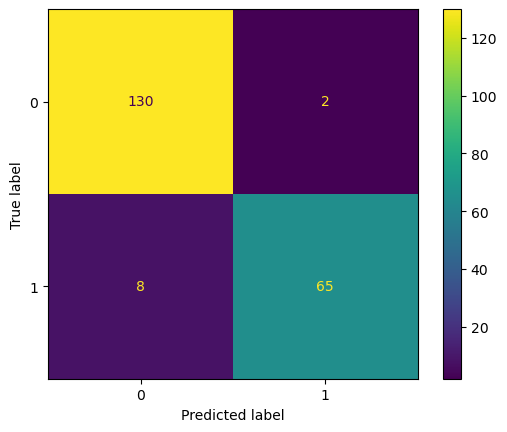

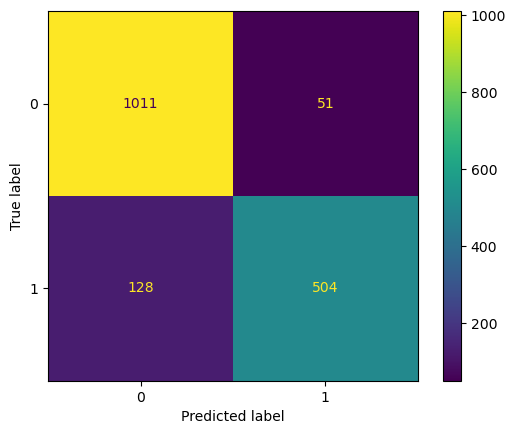

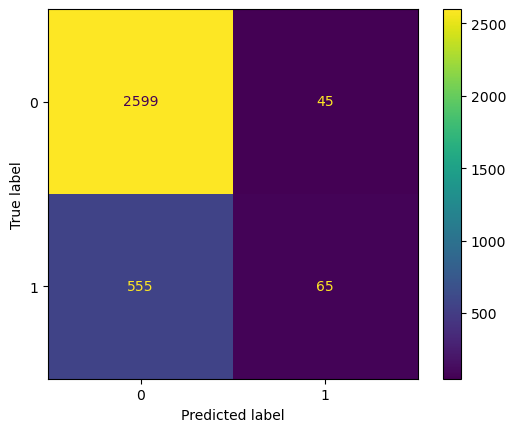

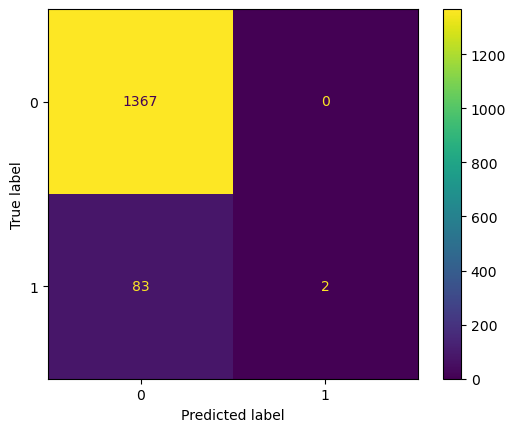

In [7]:
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ab = AdaBoost()
    ab.fit(X_train, y_train)
    plot_cm(ab, X_test, y_test)

We figured we could take another look at the algorithm's behaviour by checking how it learns when raising and lowering the train size.  
`plot_learning_curves` was used to plot the Learning Curve of the fitted model. We ran 10 tests with training size = `tr_size` and stored all accuracy results in a line of train_scores and test_scores.   
Finally, we were able to get the mean training score and the standard deviation for each train size and plot the learning curves.

In [8]:
def plot_learning_curves(model, X, y, title=''):
    training_size = np.linspace(0.1,0.9,10)
    train_scores = {}
    test_scores = {}
    for tr_size in training_size:
        train_scores[tr_size] = []
        test_scores[tr_size] = []
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=tr_size)
            model.fit(X_train, y_train)
            training_pred = model.predict(X_train)
            testing_pred = model.predict(X_test)
            train_scores[tr_size].append(accuracy_score(training_pred, y_train))
            test_scores[tr_size].append(accuracy_score(testing_pred, y_test))
        print(
            f"Train size: {tr_size}\n \
            Mean training score: {round(np.mean(train_scores[tr_size]), 5)}\n \
            Standard deviation: {round(np.std(train_scores[tr_size]), 5)}"
        )

    train_mean = np.array([np.mean(train_scores[tr_size]) for tr_size in training_size])
    train_std = np.array([np.std(train_scores[tr_size]) for tr_size in training_size])
    test_mean = np.array([np.mean(test_scores[tr_size]) for tr_size in training_size])
    test_std = np.array([np.std(test_scores[tr_size]) for tr_size in training_size])

    plt.figure(figsize=(8, 6))
    plt.plot(training_size, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(training_size, test_mean, 'o-', color='green', label='Test score')
    plt.fill_between(training_size, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(training_size, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()

Train size: 0.1
             Mean training score: 1.0
             Standard deviation: 0.0
Train size: 0.18888888888888888
             Mean training score: 0.98837
             Standard deviation: 0.00933
Train size: 0.2777777777777778
             Mean training score: 0.98783
             Standard deviation: 0.01253
Train size: 0.3666666666666667
             Mean training score: 0.9748
             Standard deviation: 0.01059
Train size: 0.4555555555555556
             Mean training score: 0.97395
             Standard deviation: 0.01041
Train size: 0.5444444444444445
             Mean training score: 0.97089
             Standard deviation: 0.00414
Train size: 0.6333333333333333
             Mean training score: 0.96944
             Standard deviation: 0.00593
Train size: 0.7222222222222222
             Mean training score: 0.96714
             Standard deviation: 0.0055
Train size: 0.8111111111111111
             Mean training score: 0.96817
             Standard deviation: 0.0044

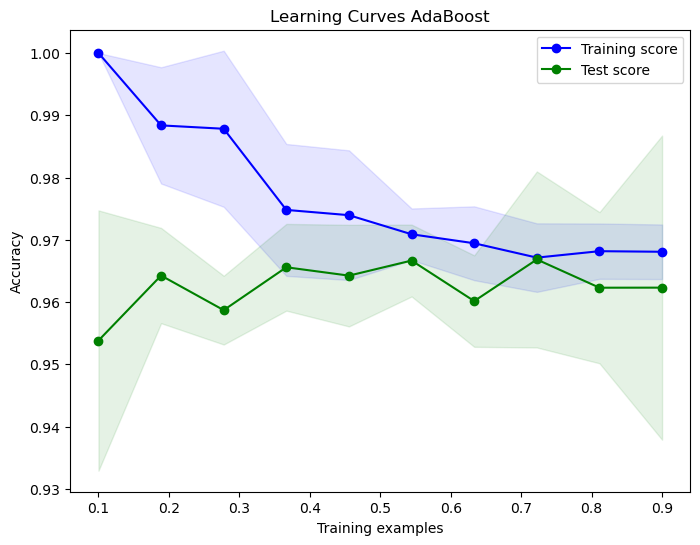

Train size: 0.1
             Mean training score: 0.91755
             Standard deviation: 0.01809
Train size: 0.18888888888888888
             Mean training score: 0.9212
             Standard deviation: 0.01762
Train size: 0.2777777777777778
             Mean training score: 0.94359
             Standard deviation: 0.02335
Train size: 0.3666666666666667
             Mean training score: 0.92929
             Standard deviation: 0.01842
Train size: 0.4555555555555556
             Mean training score: 0.93543
             Standard deviation: 0.03034
Train size: 0.5444444444444445
             Mean training score: 0.93197
             Standard deviation: 0.02542
Train size: 0.6333333333333333
             Mean training score: 0.93436
             Standard deviation: 0.01809
Train size: 0.7222222222222222
             Mean training score: 0.93501
             Standard deviation: 0.01706
Train size: 0.8111111111111111
             Mean training score: 0.9355
             Standard deviation

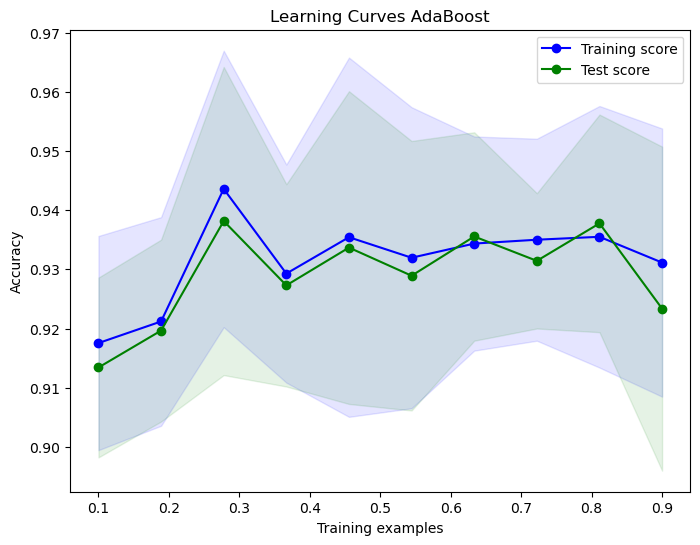

Train size: 0.1
             Mean training score: 0.8057
             Standard deviation: 0.00961
Train size: 0.18888888888888888
             Mean training score: 0.8144
             Standard deviation: 0.00687
Train size: 0.2777777777777778
             Mean training score: 0.8131
             Standard deviation: 0.00555
Train size: 0.3666666666666667
             Mean training score: 0.81101
             Standard deviation: 0.00501
Train size: 0.4555555555555556
             Mean training score: 0.81197
             Standard deviation: 0.00412
Train size: 0.5444444444444445
             Mean training score: 0.80924
             Standard deviation: 0.00315
Train size: 0.6333333333333333
             Mean training score: 0.80898
             Standard deviation: 0.00416
Train size: 0.7222222222222222
             Mean training score: 0.80928
             Standard deviation: 0.00273
Train size: 0.8111111111111111
             Mean training score: 0.80916
             Standard deviation:

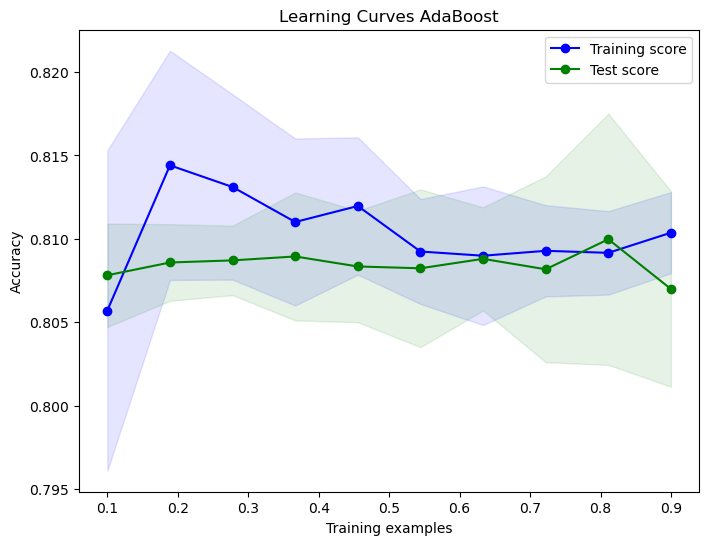

Train size: 0.1
             Mean training score: 0.94928
             Standard deviation: 0.01081
Train size: 0.18888888888888888
             Mean training score: 0.94902
             Standard deviation: 0.00822
Train size: 0.2777777777777778
             Mean training score: 0.94725
             Standard deviation: 0.00431
Train size: 0.3666666666666667
             Mean training score: 0.9487
             Standard deviation: 0.00433
Train size: 0.4555555555555556
             Mean training score: 0.94773
             Standard deviation: 0.00329
Train size: 0.5444444444444445
             Mean training score: 0.94677
             Standard deviation: 0.00424
Train size: 0.6333333333333333
             Mean training score: 0.94843
             Standard deviation: 0.0062
Train size: 0.7222222222222222
             Mean training score: 0.9508
             Standard deviation: 0.00559
Train size: 0.8111111111111111
             Mean training score: 0.94704
             Standard deviation:

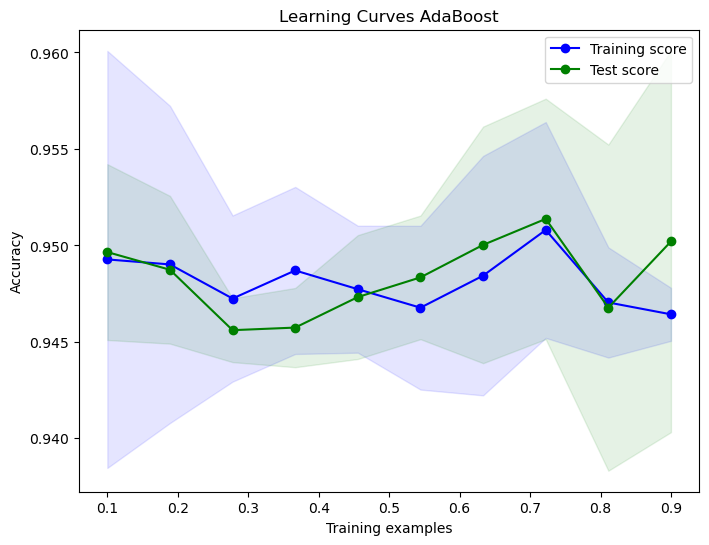

In [9]:
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    ab = AdaBoost()
    plot_learning_curves(ab, X, y, title="AdaBoost")

Since the ROC Curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for various threshold values, it allows us to, once again, have a visual interpretation of AdaBoost's performance.  
Due to its robustness to class imbalance and threshold-independancy, we also believed the AUC Score to be a good measure of how good our chosen classifier was.  
We used `plot_roc_curve` to acquire both.

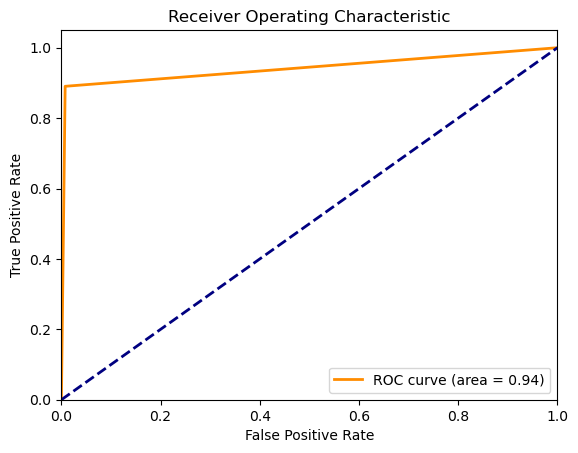

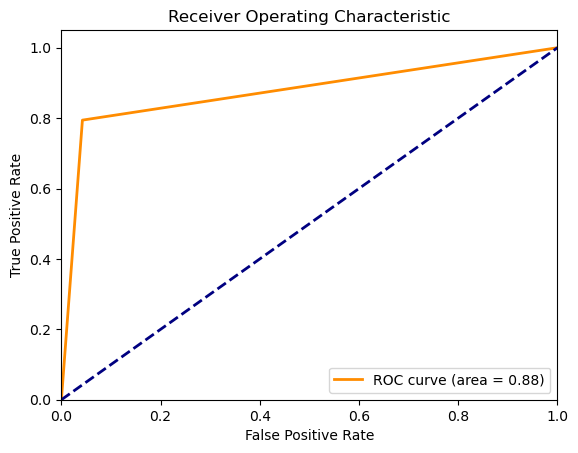

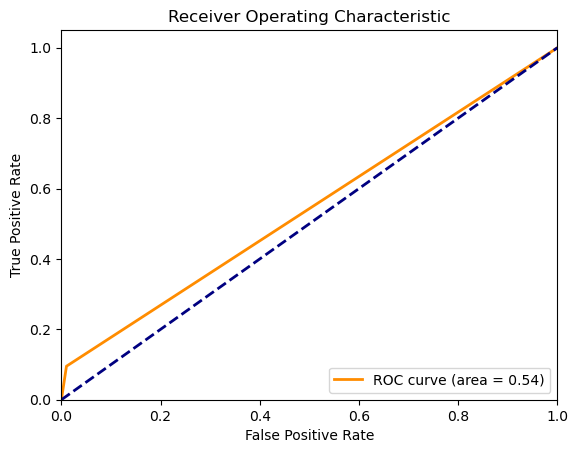

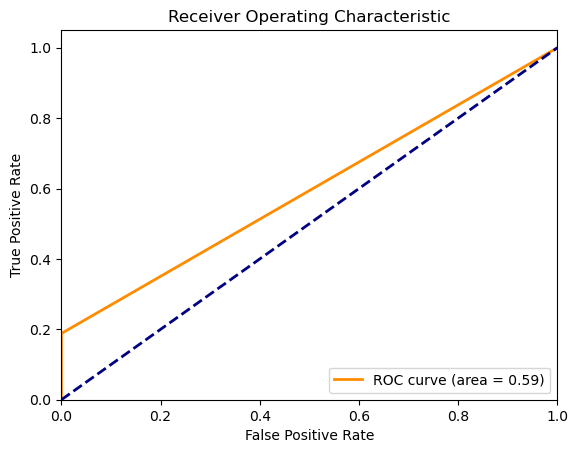

In [10]:
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
for ds_id, ds in datasets:
    ada_boost = AdaBoost()
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ada_boost.fit(X_train, y_train)
    y_pred = ada_boost.predict(X_test)
    plot_roc_curve(y_test, y_pred)

### Comparison of base algorithm and modified ones

Definition of the models:
- `default` is the default AdaBoost classifier.
- `Alpha Changed` is the AdaBoost classifier with a different method to calculate alpha, the value used when updating the sample weights. In this model, the alpha value is directly proportional to the error - in other words, alpha == error.
- `Duplicate Misclassified` is the AdaBoost classifier that, at each iteration, duplicates misclassified samples with a given probability P. P is calculated by dividing the number of new misclassified samples by the total size of samples (including previously added ones).
- `Alpha Changed & Duplicate Misclassified` combines both of the two previous methods.

In [11]:
models = [
    ("default", AdaBoost()),
    ("Alpha Changed", AdaBoost(alpha_type=1)),
    ("Duplicate Misclassified", AdaBoost(duplicate=True)),
    ("Alpha Changed & Duplicate Misclassified", AdaBoost(alpha_type=1, duplicate=True))
]

`plot_cv` plots the results from 10-fold Cross Validation for the 4 used algorithms. We applied this function to each dataset.

In [12]:
def plot_cv(results_cv,metric='Accuracy', title="Cross-validation results for multiple algorithms in a single task"):
    fig, ax = plt.subplots()
    ax.boxplot(results_cv)
    ax.set_xticklabels(results_cv.columns)
    ax.set_ylabel(metric)
    ax.set_title(title)
    plt.show()

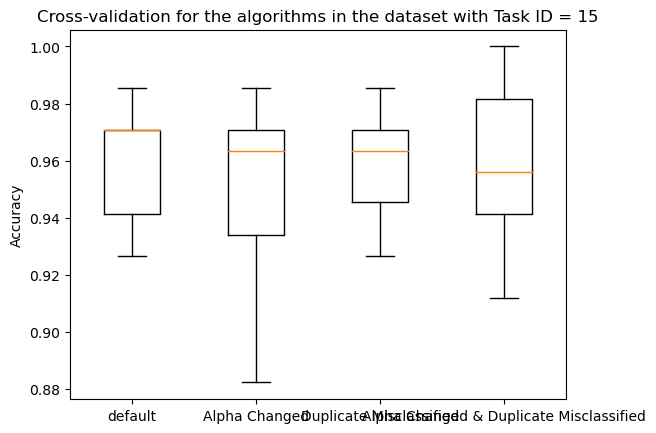

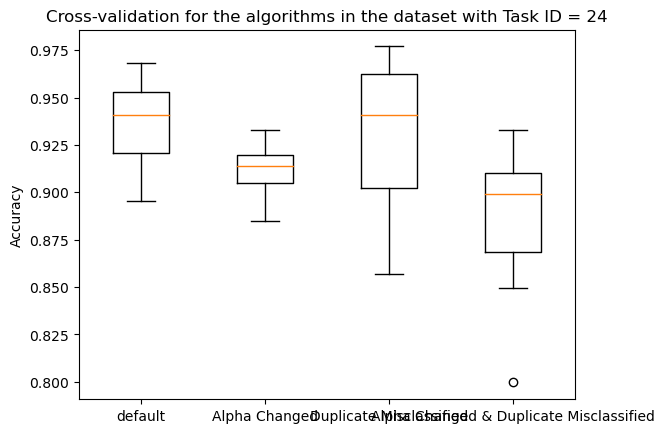

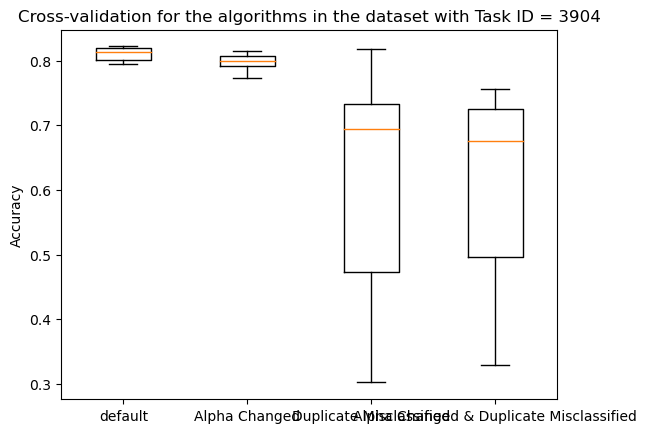

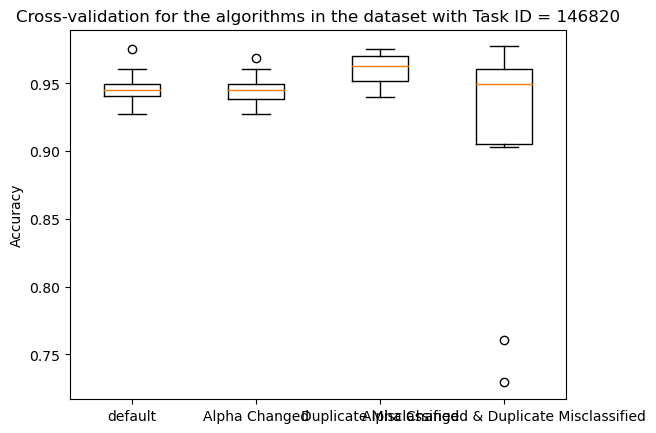

In [13]:
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']
    results = run_cv(X, y, models)
    plot_cv(results, title=f"Cross-validation for the algorithms in the dataset with {ds_id}")

In [14]:
def run_cv_per_dataset(datasets, algs):
    table = pd.DataFrame()
    for ds_id, ds in datasets:
        X = ds.drop(columns=['target'], axis=1)
        y = ds['target']
        result_ds = run_cv(X, y, algs, means_only=True)
        table = pd.concat([table, result_ds], ignore_index=True)
    return table

In [15]:
table = run_cv_per_dataset(datasets, models)
table

,default,Alpha Changed,Duplicate Misclassified,Alpha Changed & Duplicate Misclassified
0,0.963427,0.960486,0.957609,0.957523
1,0.929657,0.919727,0.936028,0.907177
2,0.808088,0.803401,0.636489,0.606434
3,0.947302,0.946062,0.961358,0.916517


In [16]:
# Use the rank method to get the ranking of classifiers per data set
def get_ranks(estimates_df,asc=False):
    results_rank = estimates_df.rank(axis=1, ascending=asc, method='min')
    results_rank.loc[len(results_rank)] = results_rank.mean()
    return results_rank

In [17]:
table_ranks = get_ranks(table)
table_ranks

,default,Alpha Changed,Duplicate Misclassified,Alpha Changed & Duplicate Misclassified
0,1.0,2.0,3.0,4.0
1,2.0,3.0,1.0,4.0
2,1.0,2.0,3.0,4.0
3,2.0,3.0,1.0,4.0
4,1.5,2.5,2.0,4.0


In [18]:
def multiple_comp(estimates_df,alpha=0.05):
    fvalue, pvalue = ss.friedmanchisquare(*[estimates_df[alg] for alg in estimates_df])
    print(f'p-value ={pvalue:.3f}')
    if pvalue >= alpha:
        print(f'There is no significant difference in performance among the algorithms')
        return None

    print(f'There is a significant difference in performance among the algorithms')
    pairedcomp = sp.posthoc_nemenyi_friedman(estimates_df)
    return(pairedcomp) 

In [19]:
paired_comparision = multiple_comp(table)

p-value =0.038
There is a significant difference in performance among the algorithms


In [20]:
def plot_multiple_comp(pairedcomp):
    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',\
    'clip_on': False, 'square': True, \
    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(pairedcomp,**heatmap_args)

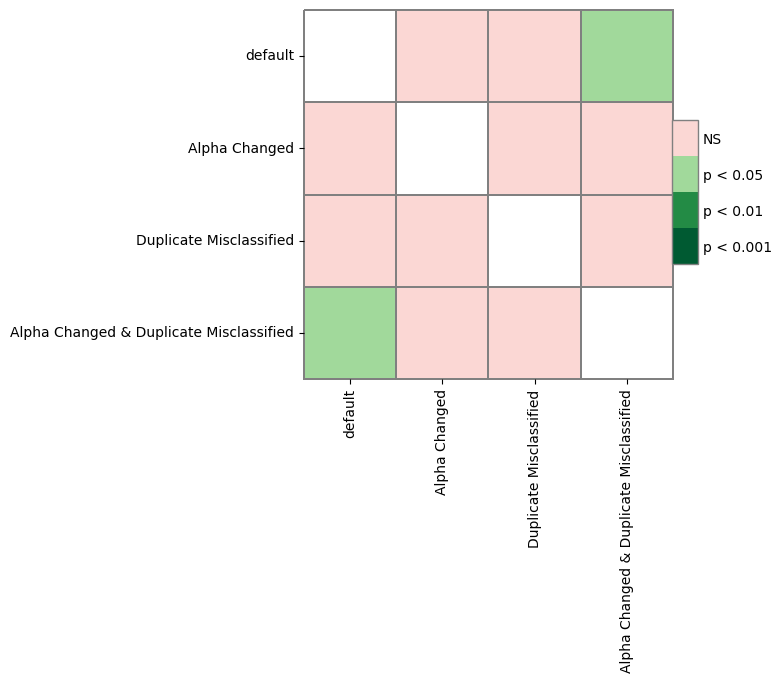

In [21]:
plot_multiple_comp(paired_comparision)